In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

c:\users\administrator\anaconda3\envs\py3.5\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\users\administrator\anaconda3\envs\py3.5\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Import the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
for fea in [ 'Pclass', 'Sex', 'SibSp',
       'Parch', 'Embarked']:
    print("feature:%s" % fea)
    print(train[fea].value_counts(dropna=False))
    print()


feature:Pclass
3    491
1    216
2    184
Name: Pclass, dtype: int64

feature:Sex
male      577
female    314
Name: Sex, dtype: int64

feature:SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

feature:Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

feature:Embarked
S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64



In [6]:
# delete   'Name', 'Ticket', 'Cabin '
train.drop(['Name', 'Cabin', 'Ticket', 'Embarked'], axis=1, inplace=True)

In [7]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,male,22.0,1,0,7.2500
1,2,1,1,female,38.0,1,0,71.2833
2,3,1,3,female,26.0,0,0,7.9250
3,4,1,1,female,35.0,1,0,53.1000
4,5,0,3,male,35.0,0,0,8.0500


In [8]:
# train['Embarked'].fillna('S', inplace=True)

In [9]:
train = pd.get_dummies(train)
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Sex_female', 'Sex_male'],
      dtype='object')

In [10]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
0,1,0,3,22.0,1,0,7.2500,0,1
1,2,1,1,38.0,1,0,71.2833,1,0
2,3,1,3,26.0,0,0,7.9250,1,0
3,4,1,1,35.0,1,0,53.1000,1,0
4,5,0,3,35.0,0,0,8.0500,0,1


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Sex_female     891 non-null uint8
Sex_male       891 non-null uint8
dtypes: float64(2), int64(5), uint8(2)
memory usage: 50.5 KB


In [12]:
train['Age'].fillna(train['Age'].median(), inplace=True)

In [13]:
target = 'Survived'
IDcol = 'PassengerId'

In [14]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
        if useTrainCV:
            xgb_param = alg.get_xgb_params()
            xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
            cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                             metrics='auc', early_stopping_rounds=early_stopping_rounds)
            alg.set_params(n_estimators=cvresult.shape[0])

            alg.fit(dtrain[predictors], dtrain[target], eval_metric='auc')
        
        dtrain_predictions = alg.predict(dtrain[predictors])
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:, 1]
        
        print ("\nModel Report")
        print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
        print ("Auc Score(Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
        
        feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8889
Auc Score(Train): 0.948316


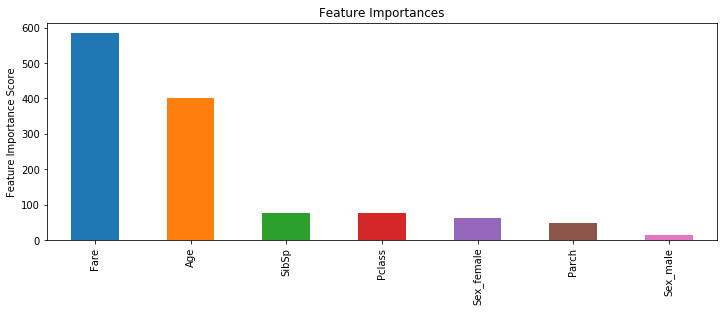

In [15]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(learning_rate=0.1,
                   n_estimators=1000,
                   max_depth=7,
                   min_child_weight=4,
                   gamma=0,
                   subsample=0.8,
                   colsample_bytree=0.8,
                   objective='binary:logistic',
                   nthread=4,
                   scale_pos_weight=1,
                   seed=27)
modelfit(xgb1, train, predictors)

In [16]:
param_test1 = {
 'max_depth':list(range(3,10,1)),
 'min_child_weight':list(range(1,6,1))
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.86555, std: 0.03347, params: {'min_child_weight': 1, 'max_depth': 3},
  mean: 0.86407, std: 0.02849, params: {'min_child_weight': 2, 'max_depth': 3},
  mean: 0.86439, std: 0.02812, params: {'min_child_weight': 3, 'max_depth': 3},
  mean: 0.86400, std: 0.02872, params: {'min_child_weight': 4, 'max_depth': 3},
  mean: 0.86686, std: 0.02575, params: {'min_child_weight': 5, 'max_depth': 3},
  mean: 0.86824, std: 0.03383, params: {'min_child_weight': 1, 'max_depth': 4},
  mean: 0.86759, std: 0.02803, params: {'min_child_weight': 2, 'max_depth': 4},
  mean: 0.86695, std: 0.02788, params: {'min_child_weight': 3, 'max_depth': 4},
  mean: 0.86846, std: 0.02980, params: {'min_child_weight': 4, 'max_depth': 4},
  mean: 0.86596, std: 0.02757, params: {'min_child_weight': 5, 'max_depth': 4},
  mean: 0.86597, std: 0.03286, params: {'min_child_weight': 1, 'max_depth': 5},
  mean: 0.86797, std: 0.02626, params: {'min_child_weight': 2, 'max_depth': 5},
  mean: 0.86721, std: 0.03036, params: {

In [17]:
param_test2 = {
 'gamma':[i/10.0 for i in list(range(0,5))]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=7,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.86726, std: 0.02909, params: {'gamma': 0.0},
  mean: 0.86797, std: 0.02913, params: {'gamma': 0.1},
  mean: 0.86799, std: 0.02965, params: {'gamma': 0.2},
  mean: 0.86775, std: 0.02838, params: {'gamma': 0.3},
  mean: 0.86712, std: 0.02915, params: {'gamma': 0.4}],
 {'gamma': 0.2},
 0.8679925655579707)

In [18]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=7,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.87179, std: 0.02841, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.86867, std: 0.02741, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.86661, std: 0.02908, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.86712, std: 0.02993, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.87179, std: 0.02841, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.86867, std: 0.02741, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.86661, std: 0.02908, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.86712, std: 0.02993, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.87001, std: 0.02592, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.87071, std: 0.02669, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.86726, std: 0.02909, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.86837, std: 0.03138, params: {'colsample_bytree': 0.8, 'subsample'

In [19]:
param_test4 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=7,
 min_child_weight=4, gamma=0, subsample=0.6, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.87237, std: 0.02902, params: {'reg_alpha': 0},
  mean: 0.87217, std: 0.02830, params: {'reg_alpha': 0.001},
  mean: 0.87074, std: 0.03026, params: {'reg_alpha': 0.005},
  mean: 0.86978, std: 0.02841, params: {'reg_alpha': 0.01},
  mean: 0.87067, std: 0.02740, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0},
 0.8723699754768643)


Model Report
Accuracy : 0.8395
Auc Score(Train): 0.885848


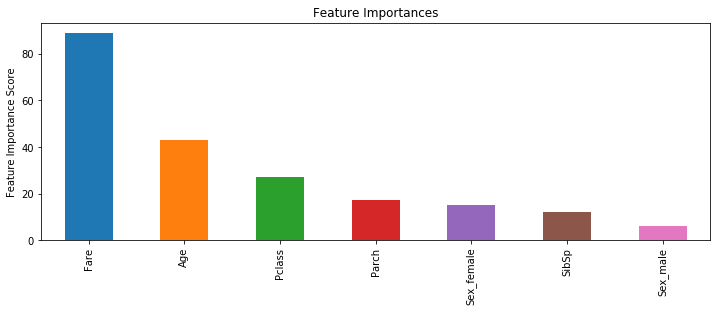

In [20]:
xgb2 = XGBClassifier(learning_rate=0.01,
                   n_estimators=1000,
                   max_depth=7,
                   min_child_weight=4,
                   gamma=0,
                   subsample=0.6,
                   colsample_bytree=0.9,
                   objective='binary:logistic',
                   nthread=4,
                   scale_pos_weight=1,
                   reg_alpha=0.005,
                   seed=27)
modelfit(xgb2, train, predictors)